# Generate Bat Outcome
 - Given the batter has made contact on the given pitch characteristics, what is the batting outcome?
 - I.e., what is the launch_speed_angle, and what is the hit_location

## Potential Difficulties:
 - How to factor in bunting?

In [125]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.features import build_features as f
from src.data import data_utils as du
from importlib import reload
reload(f)

vladdy = 665489
soto = 665742
schneider = 676914
biggio = 624415
batter = soto
X_train, y_train, X_test, y_test, encoders = f.get_hit_outcome_dataset(batter, split=True)

In [135]:
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold

xgb_regressor = xgb.XGBRegressor()
multioutput_regressor = MultiOutputRegressor(xgb_regressor)
multioutput_regressor.fit(X_train, y_train)
y_pred = multioutput_regressor.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 546.1490182705911


In [141]:
import numpy as np
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error

# Define base XGBoost regressor
xgb_regressor = xgb.XGBRegressor()

# Wrap XGBoost regressor with MultiOutputRegressor
multioutput_regressor = MultiOutputRegressor(xgb_regressor)

# Define hyperparameters to search
param_grid = {
    'estimator__max_depth': [3],               # Maximum depth of a tree
    'estimator__min_child_weight': [5],         # Minimum sum of instance weight needed in a child
    'estimator__gamma': [0, 0.1, 0.2],                # Minimum loss reduction required to make a further partition on a leaf node
    'estimator__subsample': [0.8, 0.9, 1.0],          # Subsample ratio of the training instance
    'estimator__colsample_bytree': [0.8, 0.9, 1.0],   # Subsample ratio of columns when constructing each tree
    'estimator__reg_alpha': [0, 0.1, 0.5],            # L1 regularization term on weights
    'estimator__reg_lambda': [1, 2, 5]                # L2 regularization term on weights
}

# Define cross-validation strategy
kfold = KFold(n_splits=5, shuffle=True)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=multioutput_regressor, param_grid=param_grid, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)
grid_result = grid_search.fit(X_train, y_train)

# Get best hyperparameters
best_params = grid_result.best_params_

# Train MultiOutputRegressor with best hyperparameters
best_multioutput_regressor = MultiOutputRegressor(xgb.XGBRegressor(**best_params))
best_multioutput_regressor.fit(X_train, y_train)

# Predictions
y_pred_train = best_multioutput_regressor.predict(X_train)
y_pred_test = best_multioutput_regressor.predict(X_test)

# Evaluate performance
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print("Best Hyperparameters:", best_params)
print("Train Mean Squared Error:", mse_train)
print("Test Mean Squared Error:", mse_test)


Best Hyperparameters: {'estimator__colsample_bytree': 1.0, 'estimator__gamma': 0.2, 'estimator__max_depth': 3, 'estimator__min_child_weight': 5, 'estimator__reg_alpha': 0, 'estimator__reg_lambda': 5, 'estimator__subsample': 1.0}
Train Mean Squared Error: 11.471297141268105
Test Mean Squared Error: 546.1490182705911


In [133]:
np.corrcoef(y_train, rowvar=False)

array([[ 1.        ,  0.36328852, -0.07093712],
       [ 0.36328852,  1.        ,  0.36708427],
       [-0.07093712,  0.36708427,  1.        ]])

In [132]:
np.corrcoef(y_pred, rowvar=False)

array([[ 1.        ,  0.37616654, -0.06805307],
       [ 0.37616654,  1.        ,  0.3390197 ],
       [-0.06805307,  0.3390197 ,  1.        ]])

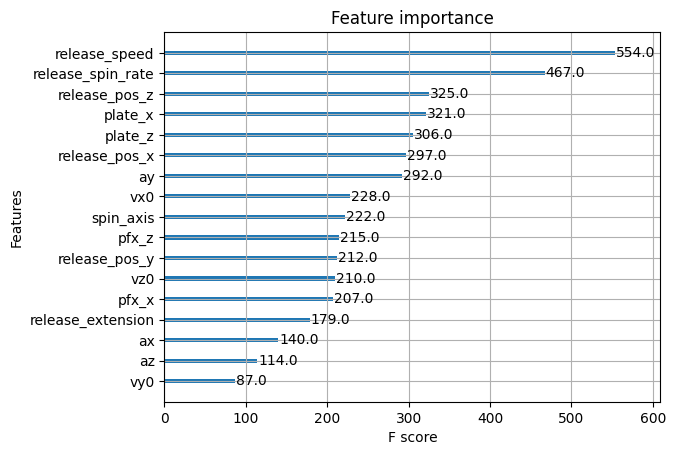

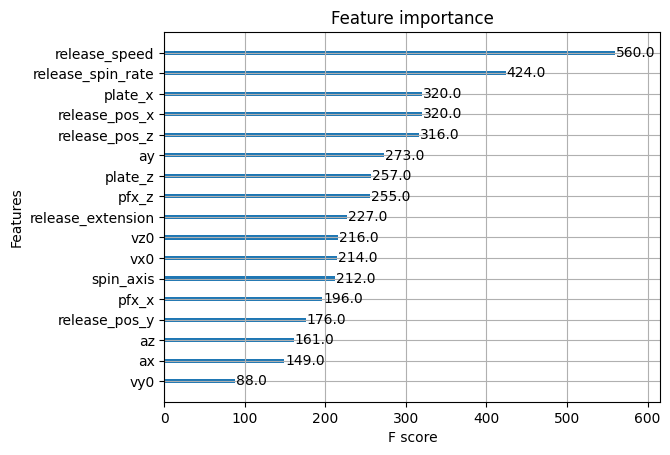

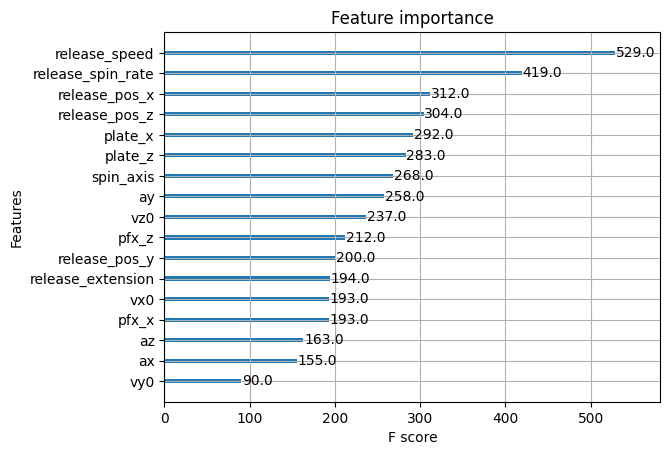

In [127]:
for i in range(0,3):
    model = multioutput_regressor.estimators_[i]
    xgb.plot_importance(model)

In [129]:
res = y_pred - y_train
res

,launch_speed,launch_angle,spray_angle
0,-1.312703,-2.511353,-0.732224
1,-1.956097,-3.779265,0.593384
2,-1.371104,5.561248,-2.021042
3,-0.623967,0.646767,0.557503
4,-2.064517,-0.754389,2.286232
...,...,...,...
2123,-1.596034,-5.681816,-2.860374
2124,-0.328938,-0.523863,1.783424
2125,-1.050467,-2.152702,2.085510
2126,-0.851964,0.409086,3.827957


In [101]:
np.corrcoef(y_train, rowvar=False)

array([[ 1.        ,  0.36328852, -0.07093712],
       [ 0.36328852,  1.        ,  0.36708427],
       [-0.07093712,  0.36708427,  1.        ]])

In [144]:
import numpy as numpy
from pprint import pprint
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from autosklearn.regression import AutoSklearnRegressor

ModuleNotFoundError: No module named 'autosklearn'

In [146]:
import requests

url = "https://baseballsavant.mlb.com/leaderboard/statcast-park-factors"

In [157]:
import json
import re

import pandas as pd
import requests
'''
LOOK THIS::: https://stackoverflow.com/questions/78307096/problem-how-to-scrape-dynamically-loaded-data-table-in-python
'''
url = "https://baseballsavant.mlb.com/leaderboard/statcast-park-factors"
url = "https://baseballsavant.mlb.com/leaderboard/statcast-park-factors?type=distance&year=2023&batSide=&stat=index_wOBA&condition=All&rolling="
response = requests.get(url)
data = re.search(r"data = (.*);", response.text).group(1)
data = json.loads(data)
df = pd.DataFrame(data)
df.columns

Index(['year', 'venue_id', 'venue_name', 'main_team_id', 'name_display_club',
       'elevation_feet', 'n', 'avg_roof', 'avg_daytime', 'avg_temperature',
       'extra_distance', 'temperature_extra_distance',
       'elevation_extra_distance', 'roof_extra_distance',
       'environment_extra_distance', 'n_year_venue_roof_for_cool_hot_code',
       'avg_temp_cool', 'extra_distance_cool', 'avg_temp_warm',
       'extra_distance_warm', 'avg_temp_hot', 'extra_distance_hot'],
      dtype='object')

In [164]:
df[['venue_name', 'extra_distance']].sort_values(by='extra_distance', ascending=False)

,venue_name,extra_distance
19,Chase Field,9.5
29,Truist Park,6.6
25,Kauffman Stadium,5.5
8,Tropicana Field,5.3
14,Globe Life Field,5.2
23,American Family Field,2.5
17,Target Field,2
20,Coors Field,18
12,Great American Ball Park,1.8
18,Yankee Stadium,-5.7
